In [449]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from livelossplot import PlotLosses
from torchvision import transforms


device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

Using device: mps


Change from a direct loading into memory to using a dataloader. The dataloader prevents this from happening, presenting an "on-demand" memory efficient loading of data. It is also well integrated into PyTorch, which simplifies the use with the models.

In our data loader here, we define both a window size (the length of the sequence), prediction size (the number of elements to be predicted) and then batch size. The output will be both X ("training") tensors, which will be of size batch size, Window size - prediction size, 1, 366, 366, and Y, which will be of size batch size, Window size - prediction size, 1, 366, 366. The window will slide linearly, in the sense that there is overlap in all the elements except the first one and last one between subsequent sequences.

In [454]:
class ImageSequenceDataset(Dataset):
    def __init__(self, directory, transform=None, window_size=10, prediction_size=3):
        self.directory = directory
        self.transform = transform
        self.window_size = window_size
        self.prediction_size = prediction_size

        # List of sorted filenames
        self.filenames = sorted([f for f in os.listdir(directory) if f.endswith('.jpg')])
        
        # Total number of sequences that can be generated given the window and prediction sizes
        self.num_sequences = len(self.filenames) - window_size + 1

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        """
        Loads at most just the sequence into memory instead of the whole dataset.
        """
        sequence_images = []

        # Calculate start and end index of the sequence
        start_idx = idx
        end_idx = idx + self.window_size

        # Load and transform each image in the sequence
        for i in range(start_idx, end_idx):
            image_path = os.path.join(self.directory, self.filenames[i])
            image = Image.open(image_path).convert('L')
            if self.transform:
                image = self.transform(image)
            sequence_images.append(image)

        # Convert list of images to tensor
        sequence_tensor = torch.stack(sequence_images)

        # Split the sequence tensor into X (input) and y (target)
        X = sequence_tensor[:self.window_size - self.prediction_size]
        y = sequence_tensor[self.window_size - self.prediction_size:]

        return X, y
    
directory = 'Selected_Storms_curated/gme'

window_size = 10
prediction_size = 3

transform = transforms.Compose([
    transforms.Resize((366, 366)),
    transforms.ToTensor(),
])


We saw that a simple convolutional LSTM worked well. The convolutional layers extract the spatial features that are interesting for the model (swirls, eyes of the storm, etc), and then the LSTM (which we use the pytorch one) will try to capture the sequential nature. We tried implementing a time aware convolutional LSTM, but we could not make it work well. 

We decided not to implement a GAN, VAE, etc for the generation, as they would produce some inherent randomness which is needed in generational models such as those. Thus, the last step outputs the image sizes.

In [455]:
class ConvLSTMModel(nn.Module):
    def __init__(self, prediction_shape):
        super(ConvLSTMModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.lstm = nn.LSTM(input_size=128 * 45 * 45, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, np.prod(prediction_shape))
        self.prediction_shape = prediction_shape

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.shape
        c_in = x.view(batch_size * seq_len, C, H, W)
        c_out = self.conv_layers(c_in)
        r_in = c_out.view(batch_size, seq_len, -1)
        r_out, _ = self.lstm(r_in)
        r_out2 = self.fc(r_out[:, -1, :])
        return r_out2.view(-1, *self.prediction_shape) 
    
prediction_shape=(prediction_size, 366, 366, 1)
model = ConvLSTMModel(prediction_shape=prediction_shape).to(device)
print(model)

ConvLSTMModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(259200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=401868, bias=True)
)


In [465]:
# Initialize the dataset
dataset = ImageSequenceDataset(
    directory='Selected_Storms_curated/gme',
    transform=transform,
    window_size=10,
    prediction_size=3
)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

first_batch = next(iter(dataloader))
X_first, y_first = first_batch

# Print the shapes
print(f'Shape of X in the first batch: {X_first.shape}')
print(f'Shape of y in the first batch: {y_first.shape}')

Shape of X in the first batch: torch.Size([2, 7, 1, 366, 366])
Shape of y in the first batch: torch.Size([2, 3, 1, 366, 366])


In [5]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

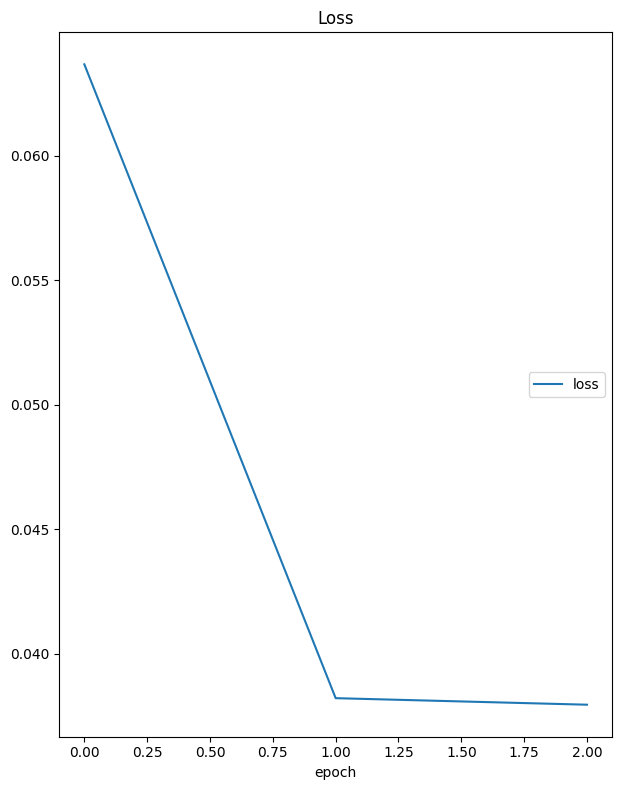

Loss
	loss             	 (min:    0.038, max:    0.064, cur:    0.038)
Epoch 3, Loss: 0.0379501043073833


In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.view(-1, *prediction_shape))  # Adjust the shape if necessary
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def train(model, dataloader, criterion, optimizer, epochs=10, device=device, plot_losses=False):
    liveloss = PlotLosses() if plot_losses else None
    
    for epoch in range(epochs):
        logs = {}
        avg_loss = train_epoch(model, dataloader, criterion, optimizer, device)
        
        # Log the average loss for this epoch
        logs['loss'] = avg_loss
        
        # Update the live plot with the latest logs
        if plot_losses:
            liveloss.update(logs)
            liveloss.send()
        
        print(f'Epoch {epoch+1}, Loss: {avg_loss}')

train(model, dataloader, criterion, optimizer, epochs=3, plot_losses=True)

In [5]:
# save model
torch.save(model.state_dict(), 'model.pt')


In [467]:

# load model
model = ConvLSTMModel(prediction_shape=prediction_shape).to(device)
model.load_state_dict(torch.load('model.pt'))
model.eval()



ConvLSTMModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(259200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=401868, bias=True)
)

This here generates images given a sequence. The training tensor is of shape batch size, input sequence length, 1, 366, 366. This means that, in our case here, to generate new images, we need to give a sequence of images, shape: [1, input sequence length, 1, 366, 366]. As we already have the tensors in our dataloader, we use that.

Given the images, we plot below the input sequence images, the generated images, and finally the difference between the generated images and the wanted output images.

torch.Size([1, 7, 1, 366, 366])


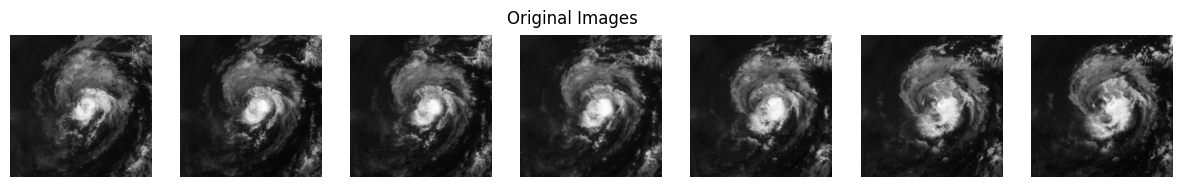

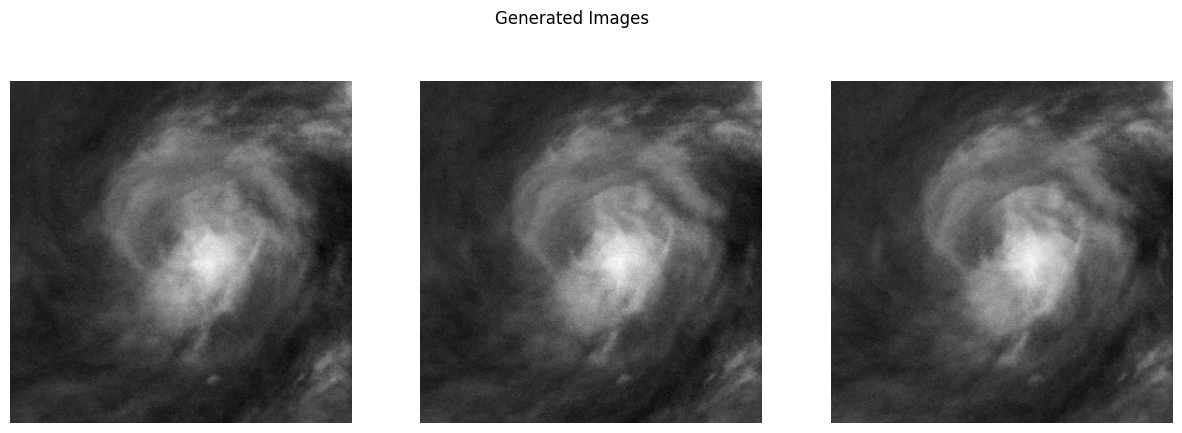

(1, 3, 366, 366)
(1, 3, 366, 366)
(1, 3, 366, 366)


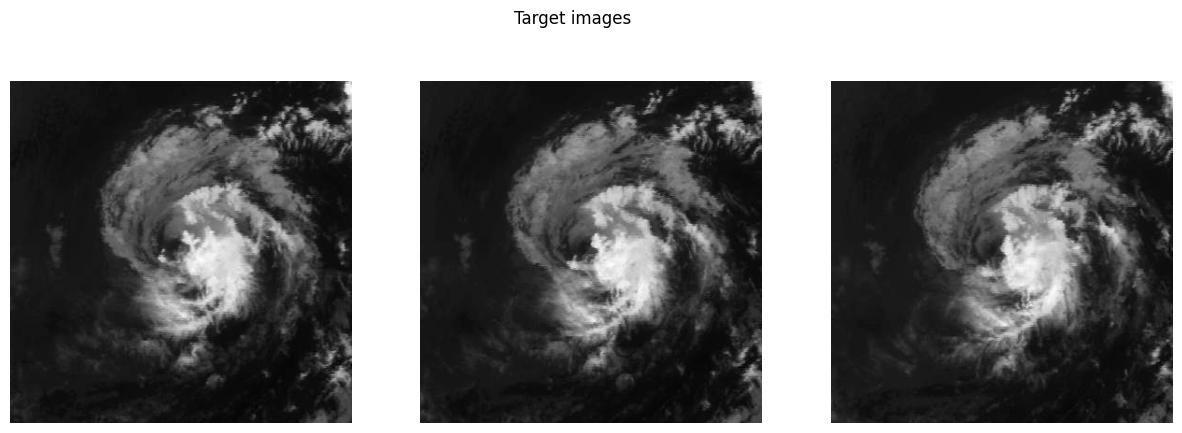

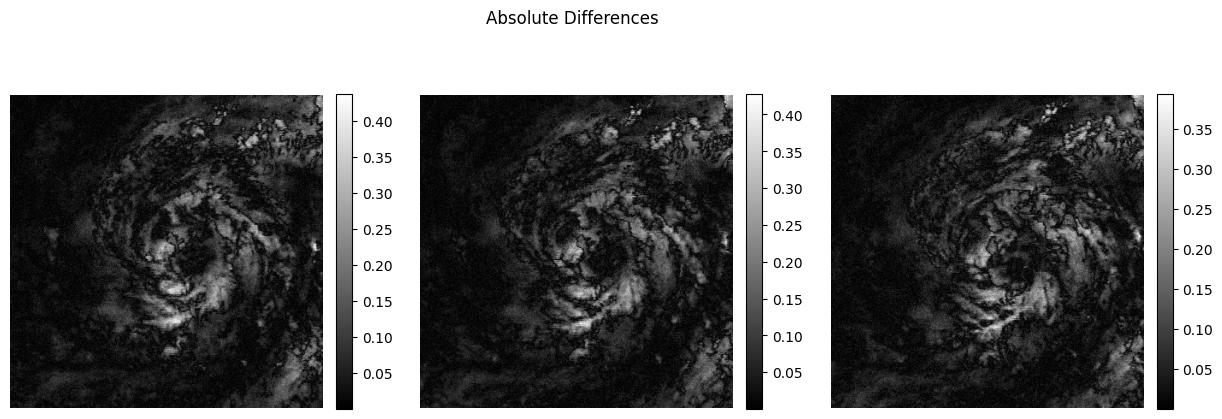

In [470]:
def generate_images(model, input_sequence, num_images=3):
    model.eval()
    with torch.no_grad():
        input_sequence = input_sequence.to(device)
        predictions = model(input_sequence)
        # Assume that the model outputs a flattened image sequence, which needs to be reshaped to match the dimensions of the image.
        predictions = predictions.view(-1, num_images, 366, 366, 1)  # Adjust to the shape of the predicted image
        #reverse_normalize(predictions)
        return predictions.cpu().numpy()  

for X_batch, y_batch in dataloader:
    pass  # Simply iterate to the end to get the final batch.

# The last batch is now contained in X_batch and y_batch
last_sequence = X_batch[-1].unsqueeze(0)
print(last_sequence.shape)

# Generate new images from the last sequence
new_images = generate_images(model, last_sequence, num_images=prediction_size)

# Function to show images remains the same
def show_images(images, title='Images', figsize=(15, 5), show_colorbar=False):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:  # If there's only one image
        axes = [axes]
    for img, ax in zip(images, axes):
        im = ax.imshow(img.squeeze(), cmap='gray')  # Squeeze to remove singleton dimensions
        ax.axis('off')
        if show_colorbar:
            fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
            # Adjust the fraction and pad to change the size and spacing of the colorbar if needed
    plt.suptitle(title)
    plt.show()

# Show the original images from the last input sequence
original_images = last_sequence.squeeze(0).cpu().numpy()  # Remove batch dimension for plotting
show_images([original_images[i] for i in range(original_images.shape[0])], title='Original Images', figsize=(15, 2))

# Display the generated images
generated_images = new_images.squeeze(0)  # Remove batch dimension for plotting
show_images([generated_images[i] for i in range(generated_images.shape[0])], title='Generated Images', figsize=(15, 5))

real_images = y_batch[-1].to(device).unsqueeze(0)  # Get the last sequence of real images and add batch dimension

# Since new_images is a numpy array, convert real_images to numpy for comparison
real_images_np = real_images.cpu().numpy()
new_images_squeezed = np.squeeze(new_images, axis=-1)  # Removes the last dimension from new_images
real_images_squeezed = np.squeeze(real_images_np, axis=2)  # Removes the third dimension from real_images_np

# Calculate the absolute differences with the adjusted arrays
absolute_differences = np.abs(new_images_squeezed - real_images_squeezed)

# Check the shape of absolute_differences
print(absolute_differences.shape)  # Should be (1, 3, 366, 366)

# Display the Real images and the absolute differences

show_images([real_images_squeezed[0, i] for i in range(real_images_squeezed.shape[1])], title='Target images', figsize=(15, 5))

show_images([absolute_differences[0, i] for i in range(absolute_differences.shape[1])], title='Absolute Differences', figsize=(15, 5), show_colorbar=True)

print("mean absolute error for each of the generated images: ")


In [471]:
# Calculate MAE for each image
mae_per_image = np.mean(absolute_differences, axis=(2, 3))  # Mean over height and width

# Calculate the mean of the real images for each image
mean_real_images = np.mean(real_images_squeezed, axis=(2, 3))  # Mean over height and width

# Avoid division by zero by adding a small constant to the mean_real_images
epsilon = 1e-8
mean_real_images += epsilon

# Approximate MRE by dividing MAE by the mean of the real images and convert to percentage
mre_approx_percentage = (mae_per_image / mean_real_images) * 100

# Print the approximated mean relative error as a percentage for each image
for i, mre in enumerate(mre_approx_percentage[0], start=1):  # Iterate over each image in the batch
    print(f"Image {i}: Approximated Mean Relative Error = {mre:.2f}%")

Image 1: Approximated Mean Relative Error = 29.85%
Image 2: Approximated Mean Relative Error = 28.86%
Image 3: Approximated Mean Relative Error = 28.55%


## Comparison of model performance

Comparing model between whole dataset usage model and one model per storm (the one we have here).

Given that the training strategies have been different, datasets are massively different, batch sizes, etc, we believe that the only way to really compare both of them is to check their performance against a set sequence we set. Given that this one was trained for storm GME, we will use that one, comparing the performance at the beginning and end of the sequence.

We define the other one here:

In [450]:
transform = transforms.Compose(
    [
        transforms.Resize((366, 366)),  # resize
        transforms.ToTensor(),
    ]
)


class ImageSequenceDataset_whole_dataset(Dataset):
    def __init__(self, data, sequence_length=6, pre_len=3, transform=None) -> None:
        super().__init__()
        self.data = data
        self.sequence_length = sequence_length
        self.pre_len = pre_len
        self.transform = transform

        self.data_id = []
        for i, d in enumerate(self.data):
            for j in range(len(d) - sequence_length - pre_len + 1):
                self.data_id.append((i, j))

        self.img_data = []
        for wd in tqdm(self.data, desc="Processing data"):
            now_img = []
            for image_path, time in wd:
                image = Image.open(image_path).convert("L")

                if self.transform:
                    image = self.transform(image)
                now_img.append(image)
            self.img_data.append(now_img)

    def __len__(self):
        return len(self.data_id)

    def __getitem__(self, idx):
        wind_id, sample_id = self.data_id[idx]
        time_start = self.data[wind_id][sample_id][
            1
        ]  # Sequence start time  time➗1000 as time embedding id

        images = []
        times = []

        for i in range(sample_id, sample_id + self.sequence_length + self.pre_len):
            image_path, time = self.data[wind_id][i]

            image = self.img_data[wind_id][i]
            images.append(image)
            time_id = (time - time_start) // 1000
            if time_id > 49:
                time_id = 49
            elif time_id < 0:
                time_id = 0

            times.append(time_id)
            time_start = time

        sequence_images = images[: self.sequence_length]
        prediction_images = images[self.sequence_length :]

        sequence_images = torch.stack(sequence_images)
        prediction_images = torch.stack(prediction_images)
        times = torch.LongTensor(times)

        return sequence_images, prediction_images, times

In [461]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2, kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=self.input_dim + self.hidden_dim,
            out_channels=4 * self.hidden_dim,
            kernel_size=self.kernel_size,
            padding=self.padding,
            bias=self.bias,
        )

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat(
            [input_tensor, h_cur], dim=1
        )  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (
            torch.zeros(
                batch_size,
                self.hidden_dim,
                height,
                width,
                device=self.conv.weight.device,
            ),
            torch.zeros(
                batch_size,
                self.hidden_dim,
                height,
                width,
                device=self.conv.weight.device,
            ),
        )


class ConvLSTM_whole_dataset(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(
        self,
        input_dim=1,
        hidden_dim=[16, 8, 1],
        kernel_size=[3, 3, 3],
        num_layers=3,
        batch_first=True,
        bias=True,
        return_all_layers=True,
    ):
        super(ConvLSTM_whole_dataset, self).__init__()

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError("Inconsistent list length.")

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        # Add and initialize parameters
        self.time_embedding = nn.Parameter(
            torch.zeros(50, 1, 366, 366), requires_grad=True
        )

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(
                ConvLSTMCell(
                    input_dim=cur_input_dim,
                    hidden_dim=self.hidden_dim[i],
                    kernel_size=self.kernel_size[i],
                    bias=self.bias,
                )
            )

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, times, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b, image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = (
            input_tensor + self.time_embedding[times[:, : input_tensor.size(1)]]
        )

        for layer_idx in range(self.num_layers):
            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](
                    input_tensor=cur_layer_input[:, t, :, :, :], cur_state=[h, c]
                )
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

In [456]:
# load model
model_per_storm = ConvLSTMModel(prediction_shape=prediction_shape).to(device)
model_per_storm.load_state_dict(torch.load('model.pt'))
model_per_storm.eval()

ConvLSTMModel(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(259200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=401868, bias=True)
)

In [463]:
model_whole_dataset = ConvLSTM_whole_dataset().to(device)
model_whole_dataset.load_state_dict(torch.load('best_model.pth', map_location=device))
model_whole_dataset.eval()

ConvLSTM_whole_dataset(
  (cell_list): ModuleList(
    (0): ConvLSTMCell(
      (conv): Conv2d(17, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ConvLSTMCell(
      (conv): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvLSTMCell(
      (conv): Conv2d(9, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
)